In [35]:
import torch
from torchvision import models,transforms
from torchvision.models import  ResNet50_Weights
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


In [36]:
# Initialize the Weight Transforms
weights = ResNet50_Weights.DEFAULT
preprocess = weights.transforms()

In [37]:
resnet50=models.resnet50(weights=weights)
resnet50
a=0
b=0
c=0
#defining hooks
def forward_pre_hook(module,inputs):
    global a
    a=inputs
def forward_hook(module,inputs,outputs):
    global b
    b=inputs
def backward_hook(module,grad_input,grad_output):
    global c
    c=grad_input

In [38]:
data=[]
#preprocessing images and storing as tensors in data array
for i in range(5):
    img = Image.open(f'ilsvrc2012-sample-images\i{i+1}.jpg') 
    l=preprocess(img)
    l.requires_grad=True
    data.append(l)
data[0].shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


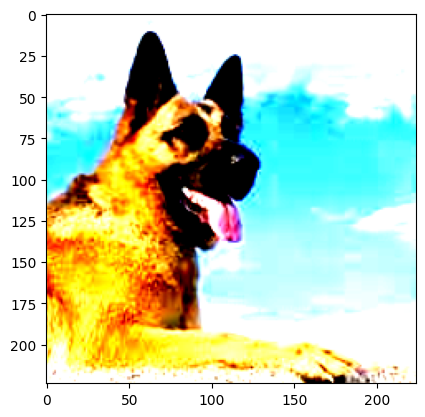

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


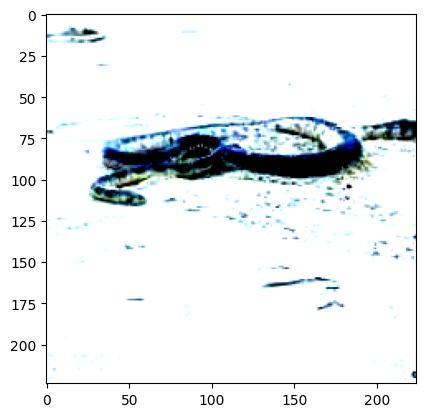

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


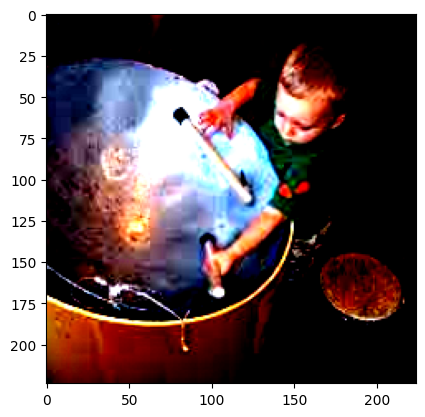

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


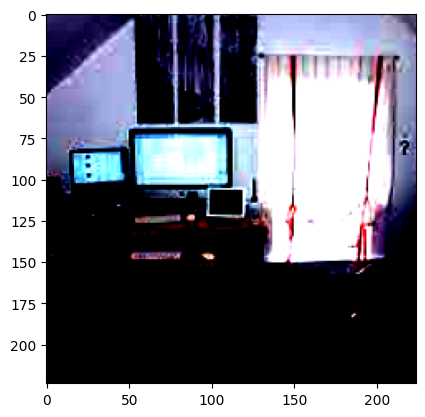

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


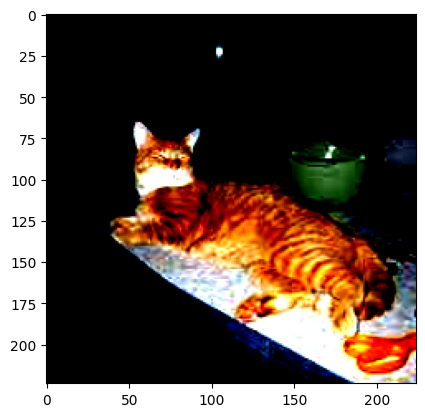

In [39]:
#displaying the images stored
for img in data:
    plt.imshow(np.array(img.permute(1,2,0).detach()))
    plt.show()

In [40]:
weights = ResNet50_Weights.DEFAULT
#creating batches of images which are sent as input
batches=[]
for i in range(5):
    batch_t=torch.unsqueeze(data[i],0)
    batches.append(batch_t)
# Put model in evaluation mode
resnet50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [41]:
#generating the predictions of images by resnet50
for i in range(5):
    prediction = resnet50(batches[i]).squeeze(0).softmax(0)
    class_id = prediction.argmax().item()
    score = prediction[class_id].item()
    category_name = weights.meta["categories"][class_id]
    print(f"{category_name}: {100 * score:.2f}%")

German shepherd: 31.06%
rock python: 28.90%
steel drum: 63.34%
desk: 13.11%
tiger cat: 10.26%


Vanilla Backprop

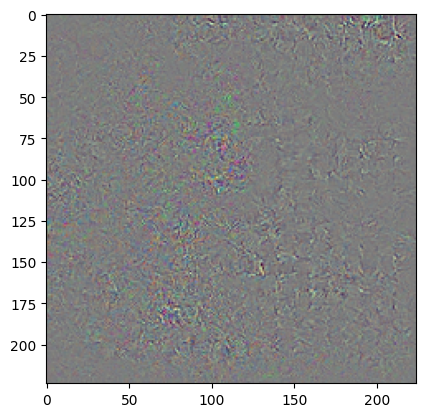

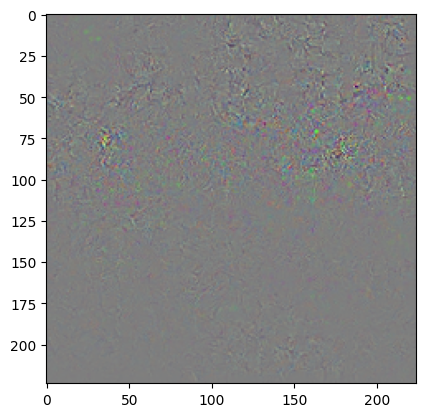

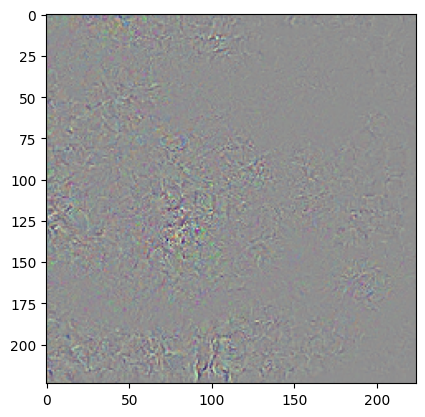

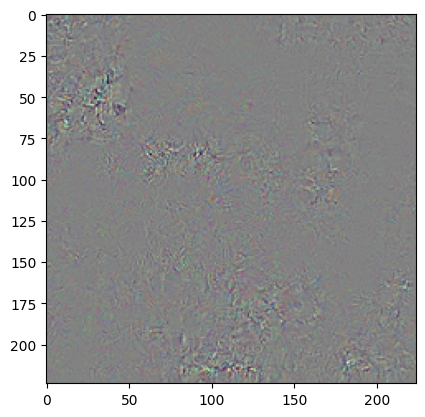

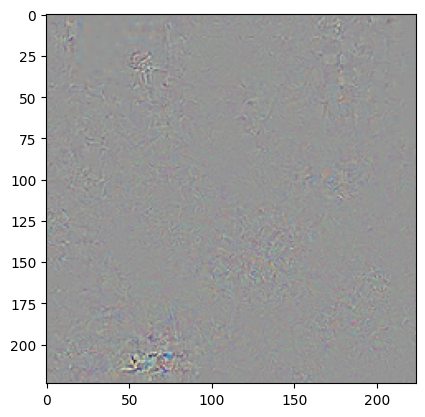

In [42]:
hook5=resnet50.conv1.register_forward_pre_hook(forward_pre_hook)
hook6=resnet50.conv1.register_forward_hook(forward_hook)
hook1=resnet50.conv1.register_backward_hook(backward_hook)
for i in range(5):
    #forward pass
    prediction = resnet50(batches[i]).squeeze(0).softmax(0)
    # Target for backprop
    temp=torch.zeros(1000)
    class_id = prediction.argmax().item()
    temp[class_id]=1
    # Backward pass
    prediction.backward(temp)
    #accessing the gradient through hook6 stored in global variable c
    grad = np.transpose(np.squeeze(c[0].detach().numpy()), (1, 2, 0))
    grad = np.uint8((grad - np.min(grad)) / (np.max(grad) - np.min(grad)) * 255)
    plt.imshow(grad)
    plt.show()
hook1.remove()
hook5.remove()
hook6.remove()

GuidedBackprop

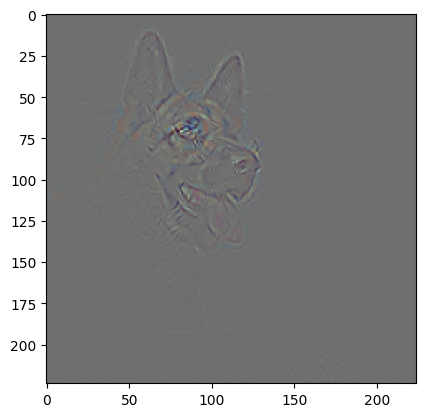

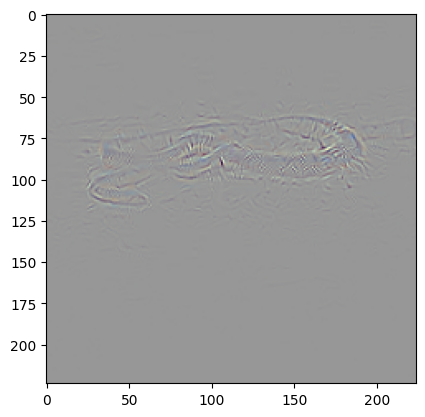

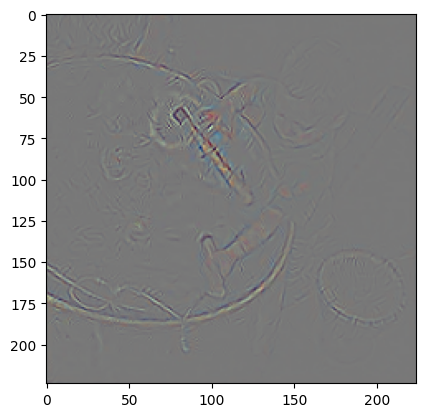

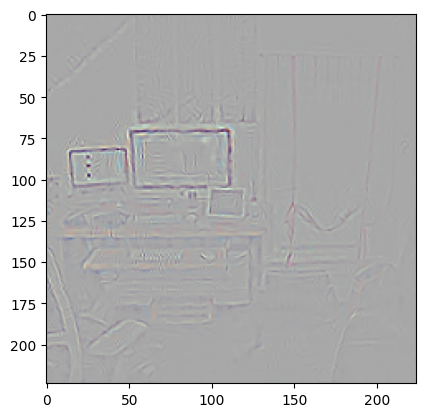

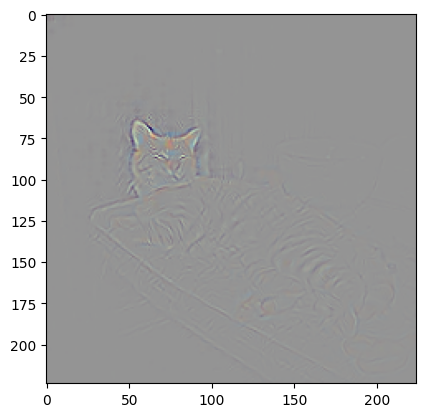

In [43]:
f=[]
for j in range(5):   
    d=0
    def hook(module, grad_in, grad_out):
        global d
        d = grad_in[0]

    # Register hook to the first layer
    first_layer = list(resnet50.children())[0]
    first_layer.register_backward_hook(hook)
    def relu_hook(module, grad_in, grad_out):
        """
        If there is a negative gradient, changes it to zero
        """
        if isinstance(module, torch.nn.ReLU):
            return (torch.clamp(grad_in[0], min=0.0),)
    # Loop through layers, hook up ReLUs with relu_hook_function
    for module in resnet50.modules():
        if isinstance(module, torch.nn.ReLU):
            module.register_backward_hook(relu_hook)
    prediction = resnet50(batches[j]).squeeze(0).softmax(0)
    # Zero gradients
    resnet50.zero_grad()
    # Target for backprop
    temp=torch.zeros(1000)
    class_id = prediction.argmax().item()
    temp[class_id]=1
    # Backward pass
    prediction.backward(temp)
    # Convert Pytorch variable to numpy array
    # [0] to get rid of the first channel (1,3,224,224)
    gradients = d.data.numpy()[0]
    gradients=np.transpose(gradients,(1,2,0))
    gradients = np.uint8((gradients - np.min(gradients)) / (np.max(gradients) - np.min(gradients)) * 255)
    plt.imshow(gradients)
    f.append(gradients)
    plt.show()

CAM


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


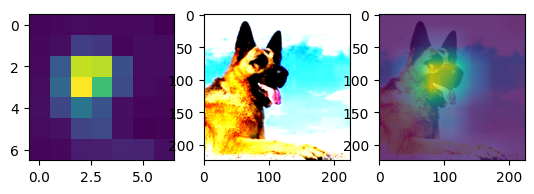

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


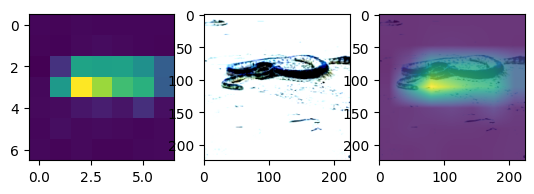

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


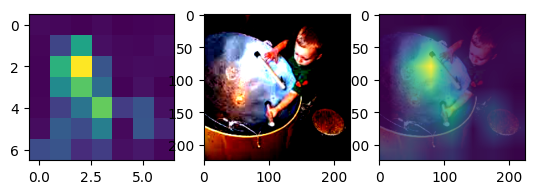

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


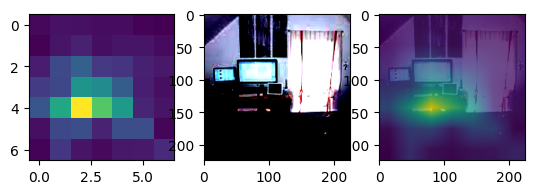

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


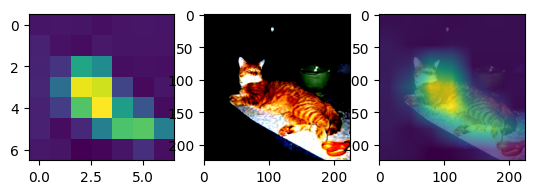

In [44]:
#registering hooks on GAP layer to get activations and weights
hook3=resnet50.avgpool.register_forward_pre_hook(forward_pre_hook)
hook4=resnet50.avgpool.register_forward_hook(forward_hook)

for i in range(5):
    #forward pass
    prediction = resnet50(batches[i]).squeeze(0).softmax(0)
    #target for backprop
    temp=torch.zeros(1000)
    class_id = prediction.argmax().item()
    temp[class_id]=1
    #backward pass
    prediction.backward(temp)
    #weights connected to most prominent class/predicted class in last layer
    temp_weights=list(resnet50.parameters())[-2][class_id].detach().numpy()
    temp_img=np.zeros((7, 7))
    #activations which are obtained by using hook4 and stored in global variable b
    temp_act=np.squeeze(b[0].detach().numpy())
    #taking weighted sum of activations and weights
    for j in range(temp_weights.shape[0]):
        temp_img=temp_img+temp_act[j]*temp_weights[j]
    #displaying  temp_img , the actual image and superposition of one over other
    plt.subplot(131)
    plt.imshow(temp_img)
    plt.subplot(132)
    plt.imshow(np.array(data[i].permute(1,2,0).detach()))
    plt.subplot(133)
    img_resize=torch.tensor(np.reshape(temp_img,(1,1,7,7)))
    img_resize=torch.nn.functional.interpolate(img_resize,size=(224,224),mode="bilinear").squeeze()
    plt.imshow(img_resize)
    plt.imshow(np.array(data[i].permute(1,2,0).detach()),alpha=0.2)
    plt.show()



Guided Grad-CAM

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


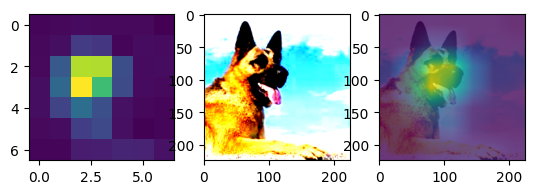

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


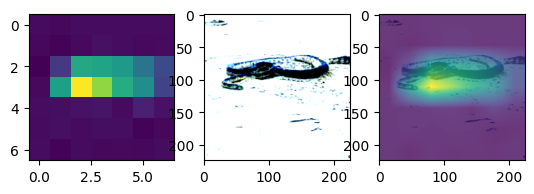

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


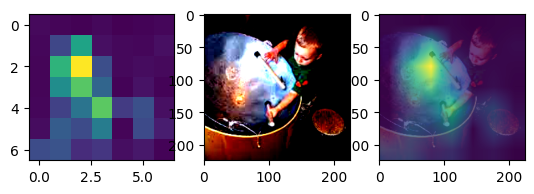

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


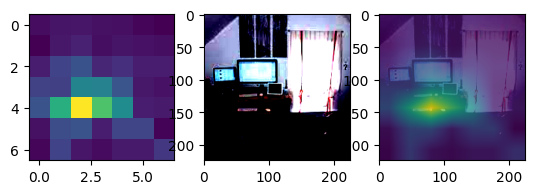

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


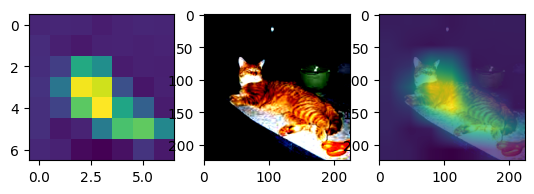

In [45]:
hook2=resnet50.avgpool.register_backward_hook(backward_hook)
for j in range(5):
    #forward pass
    prediction = resnet50(batches[j]).squeeze(0).softmax(0)
    #target for backprop
    temp=torch.zeros(1000)
    class_id = prediction.argmax().item()
    temp[class_id]=1
    #backward pass
    prediction.backward(temp)
    #The weights here used are mean of gradient of most activated output wrt the activations, given by hook2 
    temp_weights=np.squeeze(c[0].detach().numpy()).squeeze()
    temp_img=np.zeros((7, 7))
    temp_act=np.squeeze(b[0].detach().numpy())
    #taking weighted sum of activations with temp_weights
    for i in range(len(temp_weights)):
        temp_img=temp_img+(np.mean(temp_weights[i])*temp_act[i])
    #displaying  temp_img , the actual image and superposition of one over other
    plt.subplot(131)
    plt.imshow(temp_img)
    plt.subplot(132)
    plt.imshow(np.array(data[j].permute(1,2,0).detach()))
    plt.subplot(133)
    img_resize=torch.tensor(np.reshape(temp_img,(1,1,7,7)))
    img_resize=torch.nn.functional.interpolate(img_resize,size=(224,224),mode="bilinear").squeeze()
    plt.imshow(img_resize)
    plt.imshow(np.array(data[j].permute(1,2,0).detach()),alpha=0.2)
    plt.show()
hook2.remove()
hook3.remove()
hook4.remove()